In [1]:
%matplotlib inline

In [6]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import ttest_rel, mannwhitneyu
import os
import nibabel as nib

opj = os.path.join

## <h1> Scan quality analysis for Memantine Project </h1>
This notebook is used to calculate temporal signal to noise ratio (tSNR) in V1, V2, V3 for all subjects and compare them across sessions. It also compares the mean framewise displacement (FD) during a scan between runs and sessions. In the first part, tSNR for each ROI and FD is plotted for each run individually. Here, you can see the interindividual differences in scan quality but also if there is a within-subject difference in scan quality between the sessions.

In the second part, I compare scan quality of placebo vs. memantine scans by calculating the significance of differences in tSNR in V1,V2,V3, and FD.

In [3]:
root_folder = '/data1/projects/Meman1/projects/pilot/derivatives/'
filenamepattern = r'sub-\d+_ses-\d+_task-2R_run-\d+_(?:hemi-(L|R)_space-fsnative|space-fsnative_hemi-(L|R))_desc-denoised_bold\.npy'

# this indicates the randomization used in the experiment
conditions = {
    'sub-001': {'ses-2': 'placebo', 'ses-3': 'memantine'},
    'sub-002': {'ses-2': 'placebo', 'ses-3': 'memantine'},
    'sub-003': {'ses-2': 'memantine', 'ses-3': 'placebo'},
    'sub-004': {'ses-2': 'memantine', 'ses-3': 'placebo'},
    'sub-005': {'ses-2': 'placebo', 'ses-3': 'memantine'},
    'sub-007': {'ses-2': 'memantine', 'ses-3': 'placebo'},
    'sub-008': {'ses-2': 'placebo', 'ses-3': 'memantine'},
    'sub-010': {'ses-2': 'placebo', 'ses-3': 'memantine'},
    'sub-012': {'ses-2': 'memantine', 'ses-3': 'placebo'},
    'sub-013': {'ses-2': 'placebo', 'ses-3': 'memantine'},
    'sub-015': {'ses-2': 'placebo', 'ses-3': 'memantine'},
    'sub-016': {'ses-2': 'memantine', 'ses-3': 'placebo'}
}

In [4]:
def get_max_mean_framewise_displacement(file_path): # function to extract FD values from fmriprep confounds file
    # READ TSV FILE
    df = pd.read_csv(file_path, sep='\t')

    # EXTRACT COLUMN WITH MEANWISE DISPLACEMENT
    displacement_column = df['framewise_displacement'][5:] # THE FIRST 5 VOLUMES WERE REMOVED DURING FITTING AS WELL SO DON'T COUNT IN CALCULATIONS
    mean_value = displacement_column.mean()
    max_value = displacement_column.max()
    return displacement_column, mean_value, max_value

## <h2>1. Calculate all necessary scan quality metrics</h2>

In [5]:
tSNR_df = pd.DataFrame(columns=['sub', 'ses', 'condition', 'run', 'tSNR_V1', 'tSNR_V2', 'tSNR_V3', 'mean_FD', 'max_FD'])

for sub in conditions.keys():              #loop over all subjects
    subfolder_pybest = opj(root_folder, 'pybest', sub)
    subfolder_fmriprep = opj(root_folder, 'fmriprep',sub)
    finalrois= opj(root_folder, 'freesurfer', sub, 'customlabel', 'roidrawing', 'final')

    #Load V1 vertices from left hemisphere, together with the number of vertices in the left hemisphere so indexing for right hemisphere works appropriately; the .label files start from 0 and work per hemisphere, whereas Inkscape merges the two hemispheres together.
    V1_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V1.label'))
    V2_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V2.label'))
    V3_lh = nib.freesurfer.read_label(opj(finalrois, 'lh.V3.label'))

    all_lh = nib.freesurfer.read_geometry(opj(root_folder, 'freesurfer', sub, 'surf', 'lh.inflated'))

    #Load V1 vertices from right hemisphere. 
    V1_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V1.label'))
    V2_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V2.label'))
    V3_rh = nib.freesurfer.read_label(opj(finalrois, 'rh.V3.label'))

    all_rh = nib.freesurfer.read_geometry(opj(root_folder, 'freesurfer', sub, 'surf', 'rh.inflated'))

    # Get the right indices for the right hemisphere by adding the number of vertices in left hemisphere to the ROI indices for the right hemisphere.
    V1_rh = V1_rh + len(all_lh[0])
    V2_rh = V2_rh + len(all_lh[0])
    V3_rh = V3_rh + len(all_lh[0])

    #Concatenate the 2 and sort them such that they are in the right order
    V1_vertices = np.sort(np.concatenate([V1_lh, V1_rh]))
    V2_vertices = np.sort(np.concatenate([V2_lh, V2_rh]))
    V3_vertices = np.sort(np.concatenate([V3_lh, V3_rh]))

    for i, session in enumerate(["ses-2", "ses-3"]):
        
        ses_folder = opj(subfolder_pybest, session, 'unzscored')
        ses_folder_fmriprep = opj(subfolder_fmriprep, session, 'func')

        if os.path.exists(ses_folder):
            print(ses_folder)
            session_pybest = sorted([filename for filename in sorted(os.listdir(ses_folder)) if re.match(filenamepattern, filename)])

            for run_nr in range(0, len(session_pybest), 2): #loop over the BOLD data from individual runs. IMPORTANT: REQUIRES APPROPRIATE FILE NUMBERING WITHIN FOLDER SO THAT ALPHABETICAL ORDER CAN BE USED FOR INDEXING
                
                # see if appropriate data was loaded
                print('hemi_L:', os.path.join(ses_folder,session_pybest[run_nr]))
                print('hemi_R:', os.path.join(ses_folder,session_pybest[run_nr+1]))

                # loading the time courses from pybest
                hemi_L = np.load(os.path.join(ses_folder,session_pybest[run_nr]))
                hemi_R = np.load(os.path.join(ses_folder,session_pybest[run_nr+1]))
                tseries = np.concatenate([hemi_L.T, hemi_R.T]) #concatenate the data

                # remove first 5 volumes, which was done during fitting as well
                tseries = tseries[:,5:]
                print(tseries.shape) # sanity check

                # calculate tSNR for all vertices in the brain
                tSNR = tseries.mean(axis=1)/tseries.std(axis=1)

                # indexing for roi_vertices and calculating the mean tSNR within each ROI
                V1_tSNR = tSNR[V1_vertices].mean()
                V2_tSNR = tSNR[V2_vertices].mean()
                V3_tSNR = tSNR[V3_vertices].mean()

                # FD calculation based on fMRIprep output
                confoundsfile = opj(ses_folder_fmriprep, f'{session_pybest[run_nr][:27]}_desc-confounds_timeseries.tsv')
                print("confoundsfile: ", confoundsfile) # sanity check

                FD, mean_FD, max_FD = get_max_mean_framewise_displacement(confoundsfile)

                # add to dataframe
                tSNR_df.loc[len(tSNR_df.index)] = [sub, session, conditions[sub][session], session_pybest[run_nr].split("_")[3], V1_tSNR, V2_tSNR, V3_tSNR, mean_FD, max_FD]

/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-2/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-2/unzscored/sub-001_ses-2_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-2/unzscored/sub-001_ses-2_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(298394, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-001/ses-2/func/sub-001_ses-2_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-2/unzscored/sub-001_ses-2_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-2/unzscored/sub-001_ses-2_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(298394, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-001/ses-2/func/sub-001_ses-2_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-2/unzscored/sub-001_ses-2_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-2/unzscored/sub-001_ses-2_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(298394, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-001/ses-2/func/sub-001_ses-2_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-2/unzscored/sub-001_ses-2_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-2/unzscored/sub-001_ses-2_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(298394, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-001/ses-2/func/sub-001_ses-2_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-2/unzscored/sub-001_ses-2_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-2/unzscored/sub-001_ses-2_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(298394, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-001/ses-2/func/sub-001_ses-2_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-2/unzscored/sub-001_ses-2_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-2/unzscored/sub-001_ses-2_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(298394, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-001/ses-2/func/sub-001_ses-2_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-3/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-3/unzscored/sub-001_ses-3_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-3/unzscored/sub-001_ses-3_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(298394, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-001/ses-3/func/sub-001_ses-3_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-3/unzscored/sub-001_ses-3_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-3/unzscored/sub-001_ses-3_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(298394, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-001/ses-3/func/sub-001_ses-3_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-3/unzscored/sub-001_ses-3_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-3/unzscored/sub-001_ses-3_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(298394, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-001/ses-3/func/sub-001_ses-3_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-3/unzscored/sub-001_ses-3_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-3/unzscored/sub-001_ses-3_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(298394, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-001/ses-3/func/sub-001_ses-3_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-3/unzscored/sub-001_ses-3_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-3/unzscored/sub-001_ses-3_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(298394, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-001/ses-3/func/sub-001_ses-3_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-3/unzscored/sub-001_ses-3_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-001/ses-3/unzscored/sub-001_ses-3_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(298394, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-001/ses-3/func/sub-001_ses-3_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-2/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-2/unzscored/sub-002_ses-2_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-2/unzscored/sub-002_ses-2_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(310783, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-002/ses-2/func/sub-002_ses-2_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-2/unzscored/sub-002_ses-2_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-2/unzscored/sub-002_ses-2_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(310783, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-002/ses-2/func/sub-002_ses-2_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-2/unzscored/sub-002_ses-2_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-2/unzscored/sub-002_ses-2_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(310783, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-002/ses-2/func/sub-002_ses-2_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-2/unzscored/sub-002_ses-2_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-2/unzscored/sub-002_ses-2_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(310783, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-002/ses-2/func/sub-002_ses-2_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-2/unzscored/sub-002_ses-2_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-2/unzscored/sub-002_ses-2_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(310783, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-002/ses-2/func/sub-002_ses-2_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-2/unzscored/sub-002_ses-2_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-2/unzscored/sub-002_ses-2_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(310783, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-002/ses-2/func/sub-002_ses-2_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-3/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-3/unzscored/sub-002_ses-3_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-3/unzscored/sub-002_ses-3_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(310783, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-002/ses-3/func/sub-002_ses-3_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-3/unzscored/sub-002_ses-3_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-3/unzscored/sub-002_ses-3_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(310783, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-002/ses-3/func/sub-002_ses-3_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-3/unzscored/sub-002_ses-3_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-3/unzscored/sub-002_ses-3_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(310783, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-002/ses-3/func/sub-002_ses-3_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-3/unzscored/sub-002_ses-3_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-3/unzscored/sub-002_ses-3_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(310783, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-002/ses-3/func/sub-002_ses-3_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-3/unzscored/sub-002_ses-3_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-3/unzscored/sub-002_ses-3_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(310783, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-002/ses-3/func/sub-002_ses-3_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-3/unzscored/sub-002_ses-3_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-002/ses-3/unzscored/sub-002_ses-3_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(310783, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-002/ses-3/func/sub-002_ses-3_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-2/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-2/unzscored/sub-003_ses-2_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-2/unzscored/sub-003_ses-2_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(336873, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-003/ses-2/func/sub-003_ses-2_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-2/unzscored/sub-003_ses-2_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-2/unzscored/sub-003_ses-2_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(336873, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-003/ses-2/func/sub-003_ses-2_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-2/unzscored/sub-003_ses-2_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-2/unzscored/sub-003_ses-2_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(336873, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-003/ses-2/func/sub-003_ses-2_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-2/unzscored/sub-003_ses-2_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-2/unzscored/sub-003_ses-2_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(336873, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-003/ses-2/func/sub-003_ses-2_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-2/unzscored/sub-003_ses-2_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-2/unzscored/sub-003_ses-2_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(336873, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-003/ses-2/func/sub-003_ses-2_task-2R_run-5_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-3/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-3/unzscored/sub-003_ses-3_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-3/unzscored/sub-003_ses-3_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(336873, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-003/ses-3/func/sub-003_ses-3_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-3/unzscored/sub-003_ses-3_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-3/unzscored/sub-003_ses-3_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(336873, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-003/ses-3/func/sub-003_ses-3_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-3/unzscored/sub-003_ses-3_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-3/unzscored/sub-003_ses-3_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(336873, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-003/ses-3/func/sub-003_ses-3_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-3/unzscored/sub-003_ses-3_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-3/unzscored/sub-003_ses-3_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(336873, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-003/ses-3/func/sub-003_ses-3_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-3/unzscored/sub-003_ses-3_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-3/unzscored/sub-003_ses-3_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(336873, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-003/ses-3/func/sub-003_ses-3_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-3/unzscored/sub-003_ses-3_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-003/ses-3/unzscored/sub-003_ses-3_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(336873, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-003/ses-3/func/sub-003_ses-3_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-2/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-2/unzscored/sub-004_ses-2_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-2/unzscored/sub-004_ses-2_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(301542, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-004/ses-2/func/sub-004_ses-2_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-2/unzscored/sub-004_ses-2_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-2/unzscored/sub-004_ses-2_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(301542, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-004/ses-2/func/sub-004_ses-2_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-2/unzscored/sub-004_ses-2_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-2/unzscored/sub-004_ses-2_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(301542, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-004/ses-2/func/sub-004_ses-2_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-2/unzscored/sub-004_ses-2_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-2/unzscored/sub-004_ses-2_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(301542, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-004/ses-2/func/sub-004_ses-2_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-2/unzscored/sub-004_ses-2_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-2/unzscored/sub-004_ses-2_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(301542, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-004/ses-2/func/sub-004_ses-2_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-2/unzscored/sub-004_ses-2_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-2/unzscored/sub-004_ses-2_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(301542, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-004/ses-2/func/sub-004_ses-2_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-3/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-3/unzscored/sub-004_ses-3_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-3/unzscored/sub-004_ses-3_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(301542, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-004/ses-3/func/sub-004_ses-3_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-3/unzscored/sub-004_ses-3_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-3/unzscored/sub-004_ses-3_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(301542, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-004/ses-3/func/sub-004_ses-3_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-3/unzscored/sub-004_ses-3_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-3/unzscored/sub-004_ses-3_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(301542, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-004/ses-3/func/sub-004_ses-3_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-3/unzscored/sub-004_ses-3_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-3/unzscored/sub-004_ses-3_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(301542, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-004/ses-3/func/sub-004_ses-3_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-3/unzscored/sub-004_ses-3_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-3/unzscored/sub-004_ses-3_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(301542, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-004/ses-3/func/sub-004_ses-3_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-3/unzscored/sub-004_ses-3_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-004/ses-3/unzscored/sub-004_ses-3_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(301542, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-004/ses-3/func/sub-004_ses-3_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-2/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-2/unzscored/sub-005_ses-2_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-2/unzscored/sub-005_ses-2_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(327099, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-005/ses-2/func/sub-005_ses-2_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-2/unzscored/sub-005_ses-2_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-2/unzscored/sub-005_ses-2_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(327099, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-005/ses-2/func/sub-005_ses-2_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-2/unzscored/sub-005_ses-2_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-2/unzscored/sub-005_ses-2_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(327099, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-005/ses-2/func/sub-005_ses-2_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-2/unzscored/sub-005_ses-2_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-2/unzscored/sub-005_ses-2_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(327099, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-005/ses-2/func/sub-005_ses-2_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-2/unzscored/sub-005_ses-2_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-2/unzscored/sub-005_ses-2_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(327099, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-005/ses-2/func/sub-005_ses-2_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-2/unzscored/sub-005_ses-2_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-2/unzscored/sub-005_ses-2_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(327099, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-005/ses-2/func/sub-005_ses-2_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-3/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-3/unzscored/sub-005_ses-3_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-3/unzscored/sub-005_ses-3_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(327099, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-005/ses-3/func/sub-005_ses-3_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-3/unzscored/sub-005_ses-3_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-3/unzscored/sub-005_ses-3_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(327099, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-005/ses-3/func/sub-005_ses-3_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-3/unzscored/sub-005_ses-3_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-3/unzscored/sub-005_ses-3_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(327099, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-005/ses-3/func/sub-005_ses-3_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-3/unzscored/sub-005_ses-3_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-3/unzscored/sub-005_ses-3_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(327099, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-005/ses-3/func/sub-005_ses-3_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-3/unzscored/sub-005_ses-3_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-3/unzscored/sub-005_ses-3_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(327099, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-005/ses-3/func/sub-005_ses-3_task-2R_run-6_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-3/unzscored/sub-005_ses-3_task-2R_run-7_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-005/ses-3/unzscored/sub-005_ses-3_task-2R_run-7_space-fsnative_hemi-R_desc-denoised_bold.npy
(327099, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-005/ses-3/func/sub-005_ses-3_task-2R_run-7_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-2/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-2/unzscored/sub-007_ses-2_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-2/unzscored/sub-007_ses-2_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(339716, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-007/ses-2/func/sub-007_ses-2_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-2/unzscored/sub-007_ses-2_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-2/unzscored/sub-007_ses-2_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(339716, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-007/ses-2/func/sub-007_ses-2_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-2/unzscored/sub-007_ses-2_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-2/unzscored/sub-007_ses-2_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(339716, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-007/ses-2/func/sub-007_ses-2_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-2/unzscored/sub-007_ses-2_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-2/unzscored/sub-007_ses-2_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(339716, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-007/ses-2/func/sub-007_ses-2_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-2/unzscored/sub-007_ses-2_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-2/unzscored/sub-007_ses-2_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(339716, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-007/ses-2/func/sub-007_ses-2_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-2/unzscored/sub-007_ses-2_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-2/unzscored/sub-007_ses-2_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(339716, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-007/ses-2/func/sub-007_ses-2_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-3/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-3/unzscored/sub-007_ses-3_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-3/unzscored/sub-007_ses-3_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(339716, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-007/ses-3/func/sub-007_ses-3_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-3/unzscored/sub-007_ses-3_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-3/unzscored/sub-007_ses-3_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(339716, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-007/ses-3/func/sub-007_ses-3_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-3/unzscored/sub-007_ses-3_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-3/unzscored/sub-007_ses-3_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(339716, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-007/ses-3/func/sub-007_ses-3_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-3/unzscored/sub-007_ses-3_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-3/unzscored/sub-007_ses-3_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(339716, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-007/ses-3/func/sub-007_ses-3_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-3/unzscored/sub-007_ses-3_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-3/unzscored/sub-007_ses-3_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(339716, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-007/ses-3/func/sub-007_ses-3_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-3/unzscored/sub-007_ses-3_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-007/ses-3/unzscored/sub-007_ses-3_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(339716, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-007/ses-3/func/sub-007_ses-3_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-2/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-2/unzscored/sub-008_ses-2_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-2/unzscored/sub-008_ses-2_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(325759, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-2/unzscored/sub-008_ses-2_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-2/unzscored/sub-008_ses-2_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(325759, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-2/unzscored/sub-008_ses-2_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-2/unzscored/sub-008_ses-2_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(325759, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-2/unzscored/sub-008_ses-2_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-2/unzscored/sub-008_ses-2_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(325759, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-2/unzscored/sub-008_ses-2_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-2/unzscored/sub-008_ses-2_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(325759, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-2/unzscored/sub-008_ses-2_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-2/unzscored/sub-008_ses-2_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(325759, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-3/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-3/unzscored/sub-008_ses-3_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-3/unzscored/sub-008_ses-3_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(325759, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-008/ses-3/func/sub-008_ses-3_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-3/unzscored/sub-008_ses-3_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-3/unzscored/sub-008_ses-3_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(325759, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-008/ses-3/func/sub-008_ses-3_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-3/unzscored/sub-008_ses-3_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-3/unzscored/sub-008_ses-3_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(325759, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-008/ses-3/func/sub-008_ses-3_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-3/unzscored/sub-008_ses-3_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-3/unzscored/sub-008_ses-3_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(325759, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-008/ses-3/func/sub-008_ses-3_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-3/unzscored/sub-008_ses-3_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-3/unzscored/sub-008_ses-3_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(325759, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-008/ses-3/func/sub-008_ses-3_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-3/unzscored/sub-008_ses-3_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-008/ses-3/unzscored/sub-008_ses-3_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(325759, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-008/ses-3/func/sub-008_ses-3_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-2/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-2/unzscored/sub-010_ses-2_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-2/unzscored/sub-010_ses-2_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(322364, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-010/ses-2/func/sub-010_ses-2_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-2/unzscored/sub-010_ses-2_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-2/unzscored/sub-010_ses-2_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(322364, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-010/ses-2/func/sub-010_ses-2_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-2/unzscored/sub-010_ses-2_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-2/unzscored/sub-010_ses-2_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(322364, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-010/ses-2/func/sub-010_ses-2_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-2/unzscored/sub-010_ses-2_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-2/unzscored/sub-010_ses-2_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(322364, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-010/ses-2/func/sub-010_ses-2_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-2/unzscored/sub-010_ses-2_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-2/unzscored/sub-010_ses-2_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(322364, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-010/ses-2/func/sub-010_ses-2_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-2/unzscored/sub-010_ses-2_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-2/unzscored/sub-010_ses-2_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(322364, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-010/ses-2/func/sub-010_ses-2_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-3/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-3/unzscored/sub-010_ses-3_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-3/unzscored/sub-010_ses-3_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(322364, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-010/ses-3/func/sub-010_ses-3_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-3/unzscored/sub-010_ses-3_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-3/unzscored/sub-010_ses-3_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(322364, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-010/ses-3/func/sub-010_ses-3_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-3/unzscored/sub-010_ses-3_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-3/unzscored/sub-010_ses-3_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(322364, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-010/ses-3/func/sub-010_ses-3_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-3/unzscored/sub-010_ses-3_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-3/unzscored/sub-010_ses-3_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(322364, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-010/ses-3/func/sub-010_ses-3_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-3/unzscored/sub-010_ses-3_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-3/unzscored/sub-010_ses-3_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(322364, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-010/ses-3/func/sub-010_ses-3_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-3/unzscored/sub-010_ses-3_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-010/ses-3/unzscored/sub-010_ses-3_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(322364, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-010/ses-3/func/sub-010_ses-3_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-2/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-2/unzscored/sub-012_ses-2_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-2/unzscored/sub-012_ses-2_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(342051, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-012/ses-2/func/sub-012_ses-2_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-2/unzscored/sub-012_ses-2_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-2/unzscored/sub-012_ses-2_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(342051, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-012/ses-2/func/sub-012_ses-2_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-2/unzscored/sub-012_ses-2_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-2/unzscored/sub-012_ses-2_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(342051, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-012/ses-2/func/sub-012_ses-2_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-2/unzscored/sub-012_ses-2_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-2/unzscored/sub-012_ses-2_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(342051, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-012/ses-2/func/sub-012_ses-2_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-2/unzscored/sub-012_ses-2_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-2/unzscored/sub-012_ses-2_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(342051, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-012/ses-2/func/sub-012_ses-2_task-2R_run-6_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-2/unzscored/sub-012_ses-2_task-2R_run-7_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-2/unzscored/sub-012_ses-2_task-2R_run-7_space-fsnative_hemi-R_desc-denoised_bold.npy
(342051, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-012/ses-2/func/sub-012_ses-2_task-2R_run-7_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-3/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-3/unzscored/sub-012_ses-3_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-3/unzscored/sub-012_ses-3_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(342051, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-012/ses-3/func/sub-012_ses-3_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-3/unzscored/sub-012_ses-3_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-3/unzscored/sub-012_ses-3_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(342051, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-012/ses-3/func/sub-012_ses-3_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-3/unzscored/sub-012_ses-3_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-3/unzscored/sub-012_ses-3_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(342051, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-012/ses-3/func/sub-012_ses-3_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-3/unzscored/sub-012_ses-3_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-3/unzscored/sub-012_ses-3_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(342051, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-012/ses-3/func/sub-012_ses-3_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-3/unzscored/sub-012_ses-3_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-3/unzscored/sub-012_ses-3_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(342051, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-012/ses-3/func/sub-012_ses-3_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-3/unzscored/sub-012_ses-3_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-012/ses-3/unzscored/sub-012_ses-3_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(342051, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-012/ses-3/func/sub-012_ses-3_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-2/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-2/unzscored/sub-013_ses-2_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-2/unzscored/sub-013_ses-2_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(324238, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-013/ses-2/func/sub-013_ses-2_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-2/unzscored/sub-013_ses-2_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-2/unzscored/sub-013_ses-2_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(324238, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-013/ses-2/func/sub-013_ses-2_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-2/unzscored/sub-013_ses-2_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-2/unzscored/sub-013_ses-2_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(324238, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-013/ses-2/func/sub-013_ses-2_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-2/unzscored/sub-013_ses-2_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-2/unzscored/sub-013_ses-2_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(324238, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-013/ses-2/func/sub-013_ses-2_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-2/unzscored/sub-013_ses-2_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-2/unzscored/sub-013_ses-2_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(324238, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-013/ses-2/func/sub-013_ses-2_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-2/unzscored/sub-013_ses-2_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-2/unzscored/sub-013_ses-2_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(324238, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-013/ses-2/func/sub-013_ses-2_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-3/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-3/unzscored/sub-013_ses-3_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-3/unzscored/sub-013_ses-3_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(324238, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-013/ses-3/func/sub-013_ses-3_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-3/unzscored/sub-013_ses-3_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-3/unzscored/sub-013_ses-3_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(324238, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-013/ses-3/func/sub-013_ses-3_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-3/unzscored/sub-013_ses-3_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-3/unzscored/sub-013_ses-3_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(324238, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-013/ses-3/func/sub-013_ses-3_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-3/unzscored/sub-013_ses-3_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-3/unzscored/sub-013_ses-3_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(324238, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-013/ses-3/func/sub-013_ses-3_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-3/unzscored/sub-013_ses-3_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-3/unzscored/sub-013_ses-3_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(324238, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-013/ses-3/func/sub-013_ses-3_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-3/unzscored/sub-013_ses-3_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-013/ses-3/unzscored/sub-013_ses-3_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(324238, 220)


divide by zero encountered in divide
invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-013/ses-3/func/sub-013_ses-3_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-2/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-2/unzscored/sub-015_ses-2_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-2/unzscored/sub-015_ses-2_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(337647, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-015/ses-2/func/sub-015_ses-2_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-2/unzscored/sub-015_ses-2_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-2/unzscored/sub-015_ses-2_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(337647, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-015/ses-2/func/sub-015_ses-2_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-2/unzscored/sub-015_ses-2_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-2/unzscored/sub-015_ses-2_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(337647, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-015/ses-2/func/sub-015_ses-2_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-2/unzscored/sub-015_ses-2_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-2/unzscored/sub-015_ses-2_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(337647, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-015/ses-2/func/sub-015_ses-2_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-2/unzscored/sub-015_ses-2_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-2/unzscored/sub-015_ses-2_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(337647, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-015/ses-2/func/sub-015_ses-2_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-2/unzscored/sub-015_ses-2_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-2/unzscored/sub-015_ses-2_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(337647, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-015/ses-2/func/sub-015_ses-2_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-3/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-3/unzscored/sub-015_ses-3_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-3/unzscored/sub-015_ses-3_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(337647, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-015/ses-3/func/sub-015_ses-3_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-3/unzscored/sub-015_ses-3_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-3/unzscored/sub-015_ses-3_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(337647, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-015/ses-3/func/sub-015_ses-3_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-3/unzscored/sub-015_ses-3_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-3/unzscored/sub-015_ses-3_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(337647, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-015/ses-3/func/sub-015_ses-3_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-3/unzscored/sub-015_ses-3_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-3/unzscored/sub-015_ses-3_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(337647, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-015/ses-3/func/sub-015_ses-3_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-3/unzscored/sub-015_ses-3_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-015/ses-3/unzscored/sub-015_ses-3_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(337647, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-015/ses-3/func/sub-015_ses-3_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-2/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-2/unzscored/sub-016_ses-2_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-2/unzscored/sub-016_ses-2_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(324105, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-016/ses-2/func/sub-016_ses-2_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-2/unzscored/sub-016_ses-2_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-2/unzscored/sub-016_ses-2_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(324105, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-016/ses-2/func/sub-016_ses-2_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-2/unzscored/sub-016_ses-2_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-2/unzscored/sub-016_ses-2_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(324105, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-016/ses-2/func/sub-016_ses-2_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-2/unzscored/sub-016_ses-2_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-2/unzscored/sub-016_ses-2_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(324105, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-016/ses-2/func/sub-016_ses-2_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-2/unzscored/sub-016_ses-2_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-2/unzscored/sub-016_ses-2_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(324105, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-016/ses-2/func/sub-016_ses-2_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-2/unzscored/sub-016_ses-2_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-2/unzscored/sub-016_ses-2_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(324105, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-016/ses-2/func/sub-016_ses-2_task-2R_run-6_desc-confounds_timeseries.tsv
/data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-3/unzscored
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-3/unzscored/sub-016_ses-3_task-2R_run-1_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-3/unzscored/sub-016_ses-3_task-2R_run-1_space-fsnative_hemi-R_desc-denoised_bold.npy
(324105, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-016/ses-3/func/sub-016_ses-3_task-2R_run-1_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-3/unzscored/sub-016_ses-3_task-2R_run-2_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-3/unzscored/sub-016_ses-3_task-2R_run-2_space-fsnative_hemi-R_desc-denoised_bold.npy
(324105, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-016/ses-3/func/sub-016_ses-3_task-2R_run-2_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-3/unzscored/sub-016_ses-3_task-2R_run-3_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-3/unzscored/sub-016_ses-3_task-2R_run-3_space-fsnative_hemi-R_desc-denoised_bold.npy
(324105, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-016/ses-3/func/sub-016_ses-3_task-2R_run-3_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-3/unzscored/sub-016_ses-3_task-2R_run-4_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-3/unzscored/sub-016_ses-3_task-2R_run-4_space-fsnative_hemi-R_desc-denoised_bold.npy
(324105, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-016/ses-3/func/sub-016_ses-3_task-2R_run-4_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-3/unzscored/sub-016_ses-3_task-2R_run-5_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-3/unzscored/sub-016_ses-3_task-2R_run-5_space-fsnative_hemi-R_desc-denoised_bold.npy
(324105, 220)


invalid value encountered in divide


confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-016/ses-3/func/sub-016_ses-3_task-2R_run-5_desc-confounds_timeseries.tsv
hemi_L: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-3/unzscored/sub-016_ses-3_task-2R_run-6_space-fsnative_hemi-L_desc-denoised_bold.npy
hemi_R: /data1/projects/Meman1/projects/pilot/derivatives/pybest/sub-016/ses-3/unzscored/sub-016_ses-3_task-2R_run-6_space-fsnative_hemi-R_desc-denoised_bold.npy
(324105, 220)
confoundsfile:  /data1/projects/Meman1/projects/pilot/derivatives/fmriprep/sub-016/ses-3/func/sub-016_ses-3_task-2R_run-6_desc-confounds_timeseries.tsv


invalid value encountered in divide


In [9]:
# look at the dataframe to see if it was done correctly
tSNR_df

,sub,ses,condition,run,tSNR_V1,tSNR_V2,tSNR_V3,mean_FD,max_FD
0,sub-001,ses-2,placebo,run-1,50.514038,52.548622,64.029182,0.068650,0.146047
1,sub-001,ses-2,placebo,run-2,55.712536,57.719589,70.860779,0.059410,0.147621
2,sub-001,ses-2,placebo,run-3,54.483597,59.193878,70.490532,0.061872,0.232449
3,sub-001,ses-2,placebo,run-4,51.258049,57.108704,67.305687,0.067608,0.248357
4,sub-001,ses-2,placebo,run-5,52.763199,54.533482,67.316200,0.062095,0.194827
...,...,...,...,...,...,...,...,...,...
137,sub-016,ses-3,placebo,run-2,21.336102,28.296669,29.414024,0.434501,4.309990
138,sub-016,ses-3,placebo,run-3,18.870068,28.159767,30.235878,0.537129,3.762537
139,sub-016,ses-3,placebo,run-4,27.378563,31.849934,34.075489,0.299497,2.816632
140,sub-016,ses-3,placebo,run-5,25.786058,32.121235,31.914808,0.368279,3.510836


In [8]:
# See if there are NaNs in the tSNR values due to zeroes in signal in one of the ROIs (should not be the case)
print('total NaNs in V1:', tSNR_df['tSNR_V1'].isna().sum())
print('total NaNs in V2:', tSNR_df['tSNR_V2'].isna().sum())
print('total NaNs in V3:', tSNR_df['tSNR_V3'].isna().sum())

print('total NaNs in mean FD:', tSNR_df['mean_FD'].isna().sum())

total NaNs in V1: 0
total NaNs in V2: 0
total NaNs in V3: 0
total NaNs in mean FD: 0


## <h2>2. Within-subject analysis of scan quality between the two sessions</h2>

First, you want to plot and test differences between the quality metrics between scans for each participant individually. Asterisks indicate significant differences between the sessions!

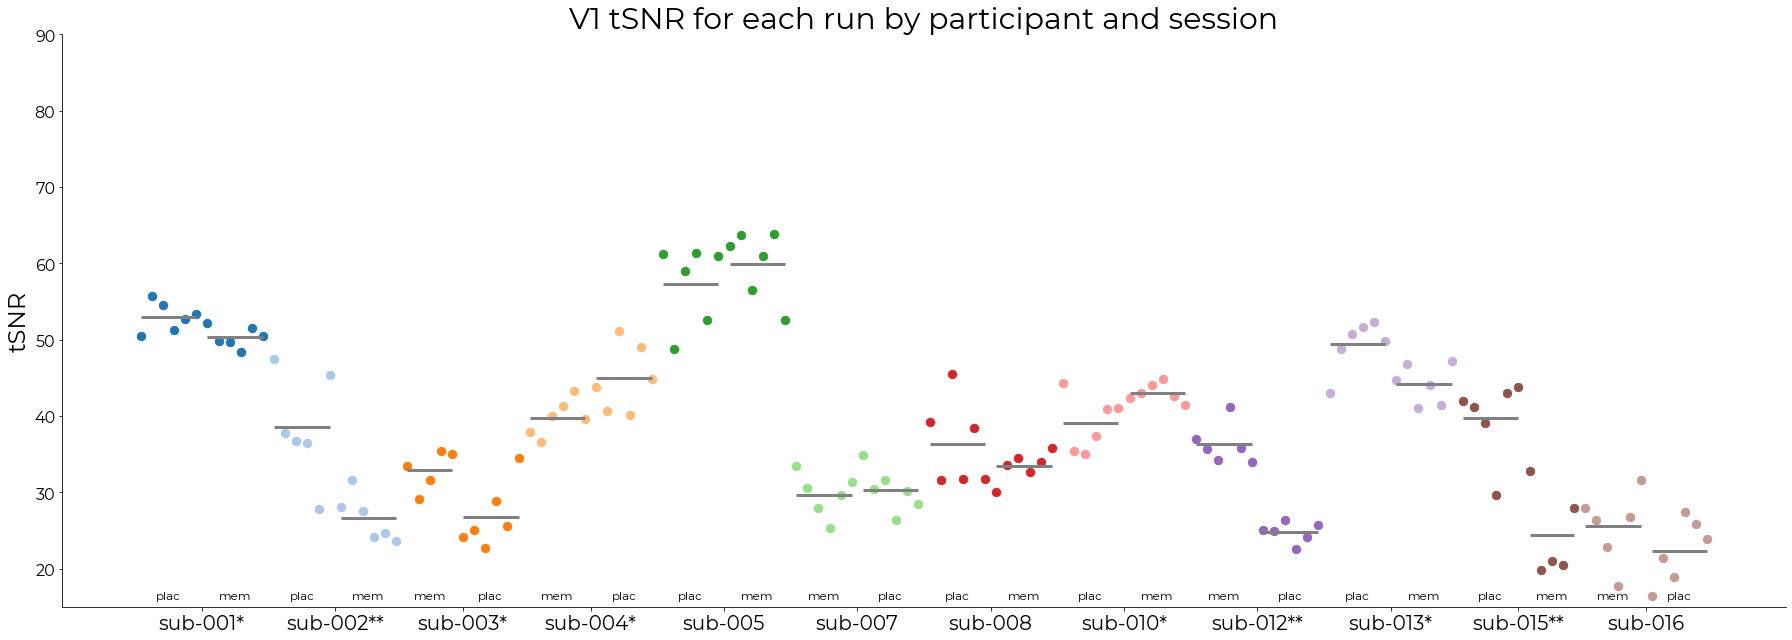

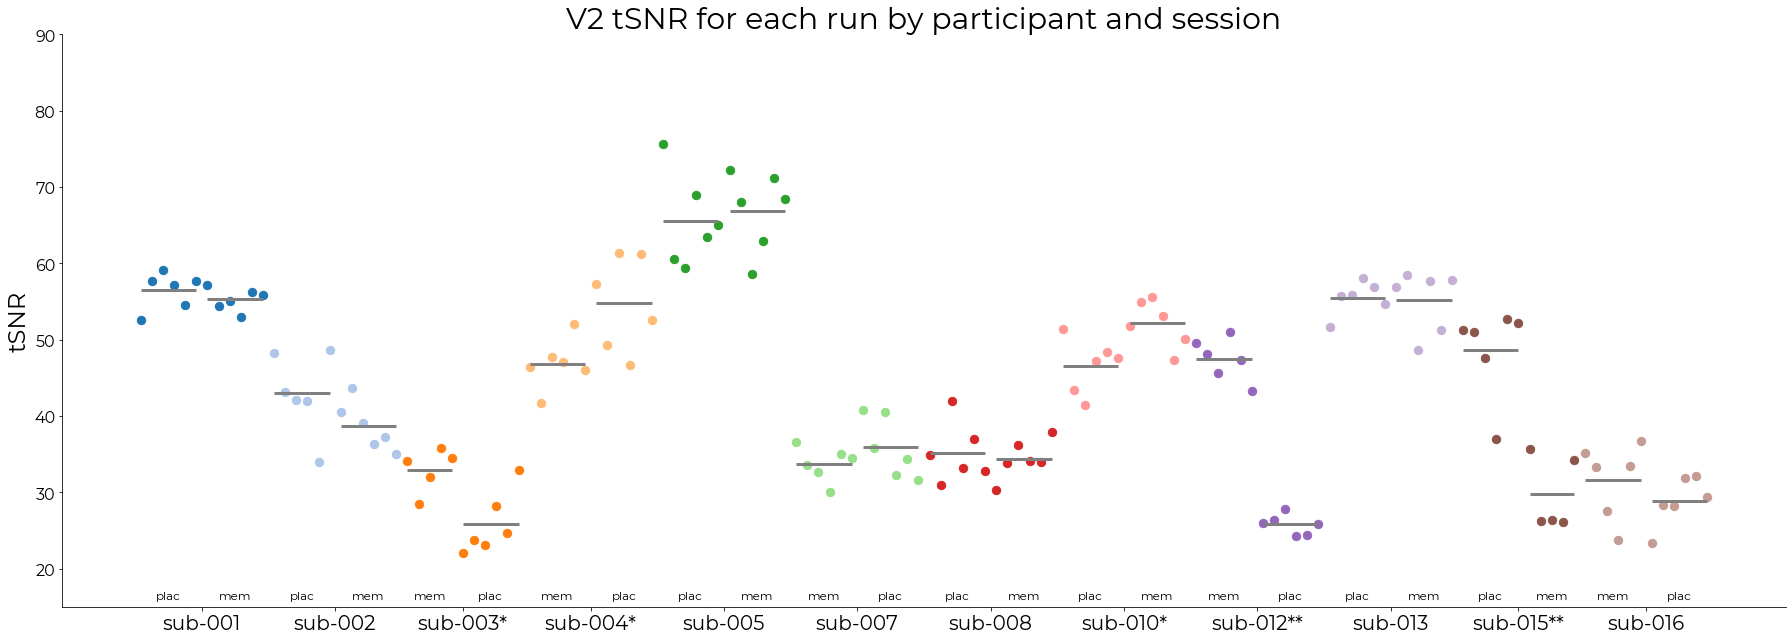

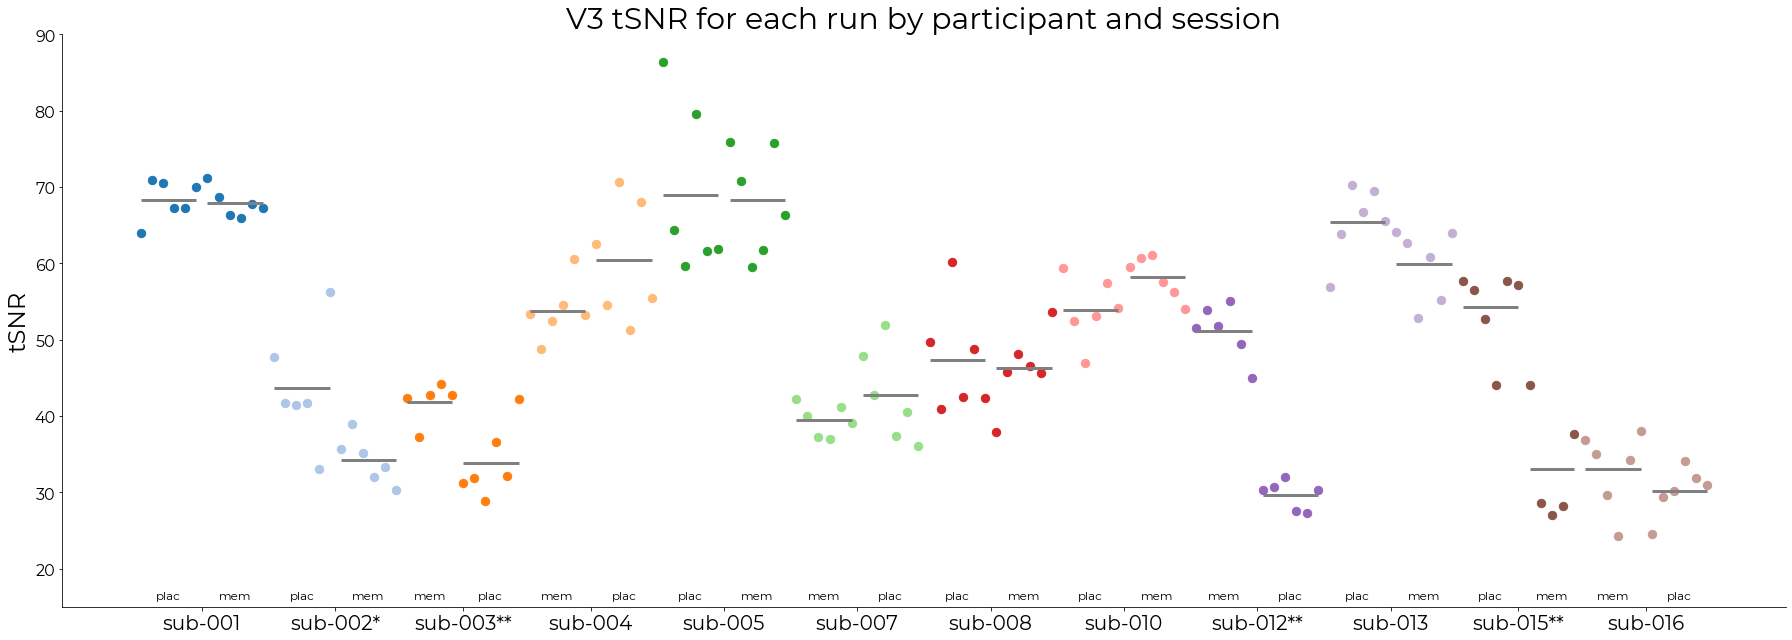

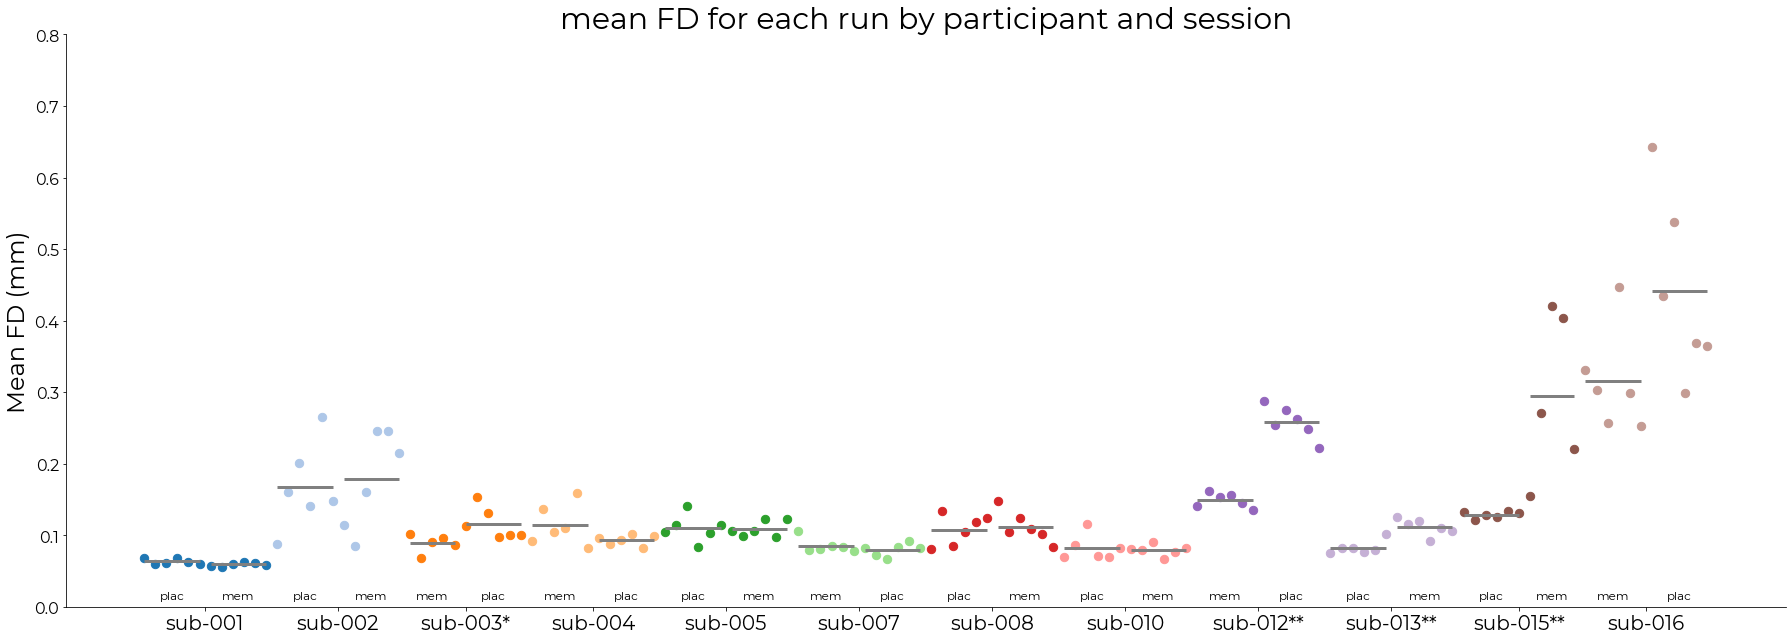

In [7]:
plt.rcParams.update({'font.family': 'Montserrat'})

# Set colors for each participant
colors = sns.color_palette('tab20', n_colors=12)
metricsofinterest=['tSNR_V1', 'tSNR_V2', 'tSNR_V3', 'mean_FD']

# loop over each scan quality metric first
for j, metric in enumerate(metricsofinterest):
    
    # create scatterplot
    plt.figure(figsize=(25, 9))
    ticklocs=[]
    subjects=[]
    plt_titles = ['V1 tSNR', 'V2 tSNR', 'V3 tSNR', 'mean FD']

    # now, loop over each subject
    for i, participant in enumerate(tSNR_df['sub'].unique()):
        participant_data = tSNR_df[tSNR_df['sub'] == participant]

        plt.scatter(participant_data.index, participant_data[metric], label=participant, color=colors[i], s=70)
        ticklocs.append(participant_data.index.values.mean())
        
        # filter data for ses-2 and ses-3
        plac_data = participant_data[participant_data['condition'] == 'placebo'][metric]
        mem_data = participant_data[participant_data['condition'] == 'memantine'][metric]
     
        # calculate difference in metric between sessions per subject
        stat, p_value = mannwhitneyu(plac_data, mem_data)
        
        # quantify significance based on p-value for plotting 
        if p_value<0.001:
            subjects.append(participant+'***')
        elif p_value<0.01:
            subjects.append(participant+'**')
        elif p_value<0.05:
            subjects.append(participant+'*')
        else:
            subjects.append(participant)

        # plot grey line which is the mean of the metric over the session
        plt.hlines(y=plac_data.mean(),xmin=min(plac_data.index), xmax=max(plac_data.index), color='grey', linewidth=3)
        plt.hlines(y=mem_data.mean(),xmin=min(mem_data.index), xmax=max(mem_data.index), color='grey', linewidth=3)

        # plot the condition below the session
        if metric in ['tSNR_V1', 'tSNR_V2', 'tSNR_V3']:
            plt.text(plac_data.index.values.mean(),16, 'plac', fontsize=12, horizontalalignment='center')
            plt.text(mem_data.index.values.mean(),16, 'mem', fontsize=12, horizontalalignment='center')
        
        else:
            plt.text(plac_data.index.values.mean(),0.01, 'plac', fontsize=12, horizontalalignment='center')
            plt.text(mem_data.index.values.mean(),0.01, 'mem', fontsize=12, horizontalalignment='center')
    
    # set labels and title
    
    if metric in ['tSNR_V1', 'tSNR_V2', 'tSNR_V3']:
        plt.ylabel('tSNR', fontsize=24)
        plt.ylim(15,90)
    
    else:
        plt.ylabel('Mean FD (mm)', fontsize=24)
        plt.ylim(0,0.8)
        
    save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/{metric}_runcomparison.png"
    
    plt.title(f'{plt_titles[j]} for each run by participant and session', fontsize=30)

    plt.xticks(ticklocs, subjects, fontsize=20)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    sns.despine()

    plt.savefig(save_path)
    plt.show()

## <h2>3. Group analysis of scan quality differences between placebo and memantine

Now, we can calculate whether there is a significant difference between the conditions on a group level:

In [10]:
# Calculate mean and SEM for each metric per session
metrics = ['tSNR_V1', 'tSNR_V2', 'tSNR_V3', 'mean_FD','max_FD']
agg_results = {}
for metric in metrics:
    agg_results[metric] = tSNR_df.groupby(['sub', 'ses', 'condition'])[metric].agg([('mean', 'mean'), ('SEM', lambda x: np.std(x) / np.sqrt(len(x)))])

# Combine results into a single DataFrame
final_df = pd.concat(agg_results, axis=1)

#Reset index to have 'Participant', 'Session', 'Condition' as columns
final_df.reset_index(inplace=True)

# Split DF into placebo and memantine
placebo_data=final_df[(final_df["condition"] == "placebo")]
memantine_data=final_df[(final_df["condition"] == "memantine")]

#drop subject 15
placebo_data = placebo_data[placebo_data['sub'] != 'sub-015']
memantine_data = memantine_data[memantine_data['sub'] != 'sub-015']

display(placebo_data)
display(memantine_data)

sub    ses condition    tSNR_V1              tSNR_V2            \
                                   mean       SEM       mean       SEM   
0   sub-001  ses-2   placebo  53.026726  0.726657  56.455532  0.910709   
2   sub-002  ses-2   placebo  38.621105  2.626276  42.980194  1.988004   
5   sub-003  ses-3   placebo  26.825539  1.592380  25.784849  1.517254   
7   sub-004  ses-3   placebo  44.942543  1.652100  54.744919  2.302718   
8   sub-005  ses-2   placebo  57.312717  1.989014  65.498322  2.246002   
11  sub-007  ses-3   placebo  30.367516  1.075030  35.890285  1.474459   
12  sub-008  ses-2   placebo  36.383980  2.121407  35.093014  1.459635   
14  sub-010  ses-2   placebo  39.018494  1.361277  46.553894  1.338835   
17  sub-012  ses-3   placebo  24.782688  0.485375  25.788849  0.501095   
18  sub-013  ses-2   placebo  49.410820  1.249100  55.511070  0.816258   
23  sub-016  ses-3   placebo  22.277611  1.555485  28.854448  1.196969   

      tSNR_V3             mean_FD              max_FD            
         mean       SEM      mean       SEM      mean       SEM  
0   68.327179  0.976188  0.063356  0.001430  0.200646  0.016887  
2   43.637287  2.892429  0.167086  0.022524  0.732108  0.116334  
5   33.836571  1.792308  0.116022  0.008292  0.680668  0.154083  
7   60.441856  2.934924  0.093544  0.002692  0.507173  0.200547  
8   68.896606  4.168919  0.110177  0.006905  0.301686  0.056307  
11  42.733738  2.292025  0.079810  0.003268  0.377462  0.047194  
12  47.399109  2.686347  0.107946  0.008113  0.890055  0.151906  
14  53.870541  1.614516  0.082257  0.006715  0.646840  0.184450  
17  29.696884  0.696848  0.258111  0.008402  2.787789  0.263325  
18  65.476189  1.792459  0.082663  0.003533  0.327664  0.056141  
23  30.195612  1.191828  0.441067  0.047422  4.152541  0.514752

sub    ses  condition    tSNR_V1              tSNR_V2            \
                                    mean       SEM       mean       SEM   
1   sub-001  ses-3  memantine  50.359337  0.513161  55.295479  0.542582   
3   sub-002  ses-3  memantine  26.619297  1.139408  38.638145  1.169383   
4   sub-003  ses-2  memantine  32.933048  1.044891  32.961941  1.146983   
6   sub-004  ses-2  memantine  39.798840  0.888395  46.824127  1.251587   
9   sub-005  ses-3  memantine  59.957462  1.687368  66.915230  1.943539   
10  sub-007  ses-2  memantine  29.712982  1.060376  33.727253  0.833607   
13  sub-008  ses-3  memantine  33.412712  0.725946  34.391647  0.949372   
15  sub-010  ses-3  memantine  43.065544  0.464113  52.154427  1.150714   
16  sub-012  ses-2  memantine  36.304890  0.972334  47.499500  1.041247   
19  sub-013  ses-3  memantine  44.228863  0.981301  55.142185  1.530590   
22  sub-016  ses-2  memantine  25.534740  1.783995  31.659950  1.853011   

      tSNR_V3             mean_FD              max_FD            
         mean       SEM      mean       SEM      mean       SEM  
1   67.877342  0.705858  0.059341  0.000930  0.162122  0.024596  
3   34.214115  1.136996  0.177968  0.025509  0.967328  0.202173  
4   41.843277  1.066877  0.088857  0.005064  0.568934  0.100590  
6   53.802105  1.422738  0.114138  0.010792  0.755831  0.188575  
9   68.351685  2.601640  0.108936  0.004237  0.349603  0.056508  
10  39.477707  0.781778  0.085401  0.003847  0.342323  0.025590  
13  46.267555  1.881205  0.111924  0.008228  0.577344  0.078230  
15  58.172047  1.031960  0.079112  0.002853  0.293308  0.031078  
16  51.103584  1.345560  0.149163  0.003743  0.948275  0.223192  
19  59.914631  1.782419  0.111564  0.004410  0.274046  0.020114  
22  33.009090  1.923653  0.315025  0.026481  6.161037  0.676958

Let's now calculate the group-level difference in quality metrics between sessions.

Framewise Displacement (mm)
mean for placebo data is 0.146, standard deviation 0.112
mean for memantine data is 0.127, standard deviation 0.07

test-statistic of paired t-test is 1.18
p-value of paired t-test is 0.265

V1 tSNR
mean for placebo data is 38.452, standard deviation 11.764
mean for memantine data is 38.357, standard deviation 10.509

test-statistic of paired t-test is 0.049
p-value of paired t-test is 0.962

V2 tSNR
mean for placebo data is 43.014, standard deviation 13.784
mean for memantine data is 45.019, standard deviation 11.631

test-statistic of paired t-test is -0.853
p-value of paired t-test is 0.414

V3 tSNR
mean for placebo data is 49.501, standard deviation 14.898
mean for memantine data is 50.367, standard deviation 12.509

test-statistic of paired t-test is -0.339
p-value of paired t-test is 0.742



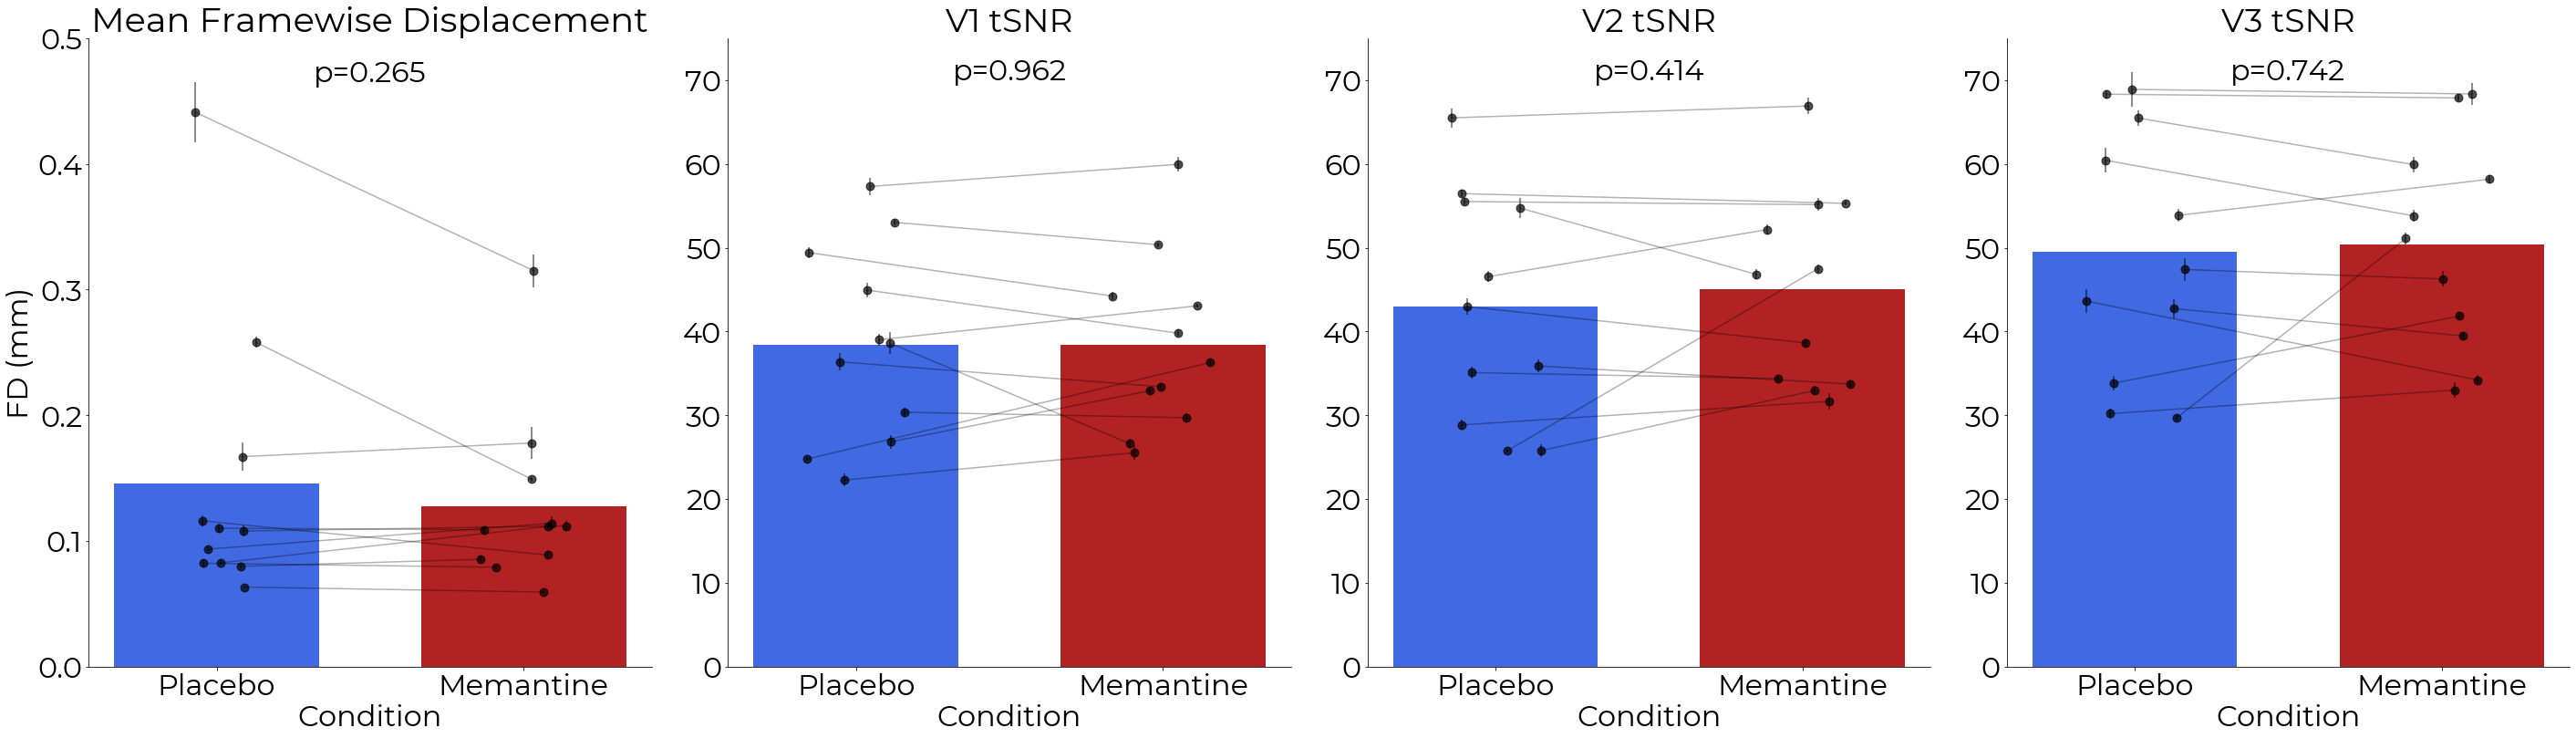

In [11]:
plt.rcParams.update({'font.size':32})
plt.rcParams.update({'font.family': 'Montserrat'})

fig, axes = plt.subplots(1,4, figsize=(40,12))

# loop over individual metrics
for i,metric in enumerate(["mean_FD","tSNR_V1", "tSNR_V2", "tSNR_V3"]):
    ax=axes[i]
    plt_titles = ['Framewise Displacement (mm)', 'V1 tSNR', 'V2 tSNR', 'V3 tSNR']
    print(plt_titles[i])

    print(f'mean for placebo data is {round(placebo_data[metric, "mean"].mean(), 3)}, standard deviation {round(placebo_data[metric,"mean"].std(), 3)}')
    print(f'mean for memantine data is {round(memantine_data[metric, "mean"].mean(), 3)}, standard deviation {round(memantine_data[metric, "mean"].std(), 3)}')
    print('')

    # perform Wilcoxon signed rank test
    stat, p_value = ttest_rel(placebo_data[metric, "mean"], memantine_data[metric, "mean"])
    print(f'test-statistic of paired t-test is {round(stat, 3)}')
    print(f'p-value of paired t-test is {round(p_value, 3)}')
    print('')

    # Plot placebo data
    ax.bar(0,placebo_data[metric, "mean"].mean(), width=0.4, color='royalblue')

    # Plot drug data
    ax.bar(0.6,memantine_data[metric, "mean"].mean(), width=0.4, color='firebrick' )

    # Add labels and title
    ax.set_xlabel('Condition')
    ax.set_xticks([0, 0.6], ['Placebo', 'Memantine'])

    if metric in ['tSNR_V1', 'tSNR_V2', 'tSNR_V3']:
        ax.text(0.3, 70,f'p={round(p_value, 3)}', horizontalalignment='center')

    else:
        ax.text(0.3, 0.465,f'p={round(p_value, 3)}', horizontalalignment='center')
   
    # Draw individual data points
    for j in range(len(placebo_data)): 
        plac_value = (0 + random.uniform(-0.1, 0.1), placebo_data.iloc[j][metric, 'mean'])
        mem_value = (0.6 + random.uniform(-0.1, 0.1), memantine_data.iloc[j][metric, 'mean'])

        #Scatter the points
        ax.scatter(plac_value[0], plac_value[1], color='black', alpha=0.7, s=80)
        ax.scatter(mem_value[0], mem_value[1], color='black', alpha=0.7, s=80)

        #Plot line between points
        ax.plot([plac_value[0], mem_value[0]], [plac_value[1], mem_value[1]], color='black', alpha=0.3)

        #Plot error bar for each point
        ax.vlines(plac_value[0],ymin=plac_value[1]-(placebo_data.iloc[j][metric, 'SEM']/2), ymax=plac_value[1]+(placebo_data.iloc[j][metric, 'SEM']/2), color='black', alpha=0.6)
        ax.vlines(mem_value[0],ymin=mem_value[1]-(memantine_data.iloc[j][metric, 'SEM']/2), ymax=mem_value[1]+(memantine_data.iloc[j][metric, 'SEM']/2), color='black', alpha=0.6)

    # Show plot
    if metric in ['tSNR_V1', 'tSNR_V2', 'tSNR_V3']:
        ax.set_ylim((0,75))
        ax.set_title(plt_titles[i], fontsize=36)
    else:
        ax.set_ylim((0,0.5))
        ax.set_ylabel('FD (mm)')
        ax.set_title("Mean Framewise Displacement")
    
    plt.tight_layout()
    sns.despine()

save_path = f"/data1/projects/Meman1/projects/pilot/code/floris/figures/scanquality_sessioncomparison.png"

plt.savefig(save_path)
plt.show()